<a href="https://colab.research.google.com/github/dbetm/DeepLearningLifeSciences/blob/main/11_virtual_screening/3_Predict_ability_inhibition_ERK2_predicting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem:** Predict the ability of molecules to inhibit a protein known as ERK2 (Mitogen Activated Protein Kinase 1, MAPK1).

ERK2 plays an important role in the signaling pathways that regulate how cells multiply. ERK2 has been implicated in a number of cancers. It's important to know some inhibitors for some types of cancer.

**Solution:** We will train the model to distinguish a set of ERK2 active compounds from a set of decoy compounds.

*What is decoy compounds?*

Decoys are molecules that are presumed to be inactive against a target (i.e. will not likely bind to the target) and are used to validate the performance of molecular docking or a virtual screening workflow.

**Database:** The active and decoy compounds are derived from the [DUD-E database](http://dud.docking.org/).

- A total of 2,950 active compounds against a total of 40 targets.
- For each active, 36 "decoys" with similar physical properties (e.g. molecular weight, calculated LogP) but dissimilar topology.

## Setup

In [1]:
!pip install --pre deepchem
import deepchem as dc
dc.__version__

     |████████████████████████████████| 609 kB 13.4 MB/s 


'2.6.0.dev'

In [2]:
# RDKIT libraries for chemistry functions
!pip install rdkit-pypi

     |████████████████████████████████| 19.7 MB 1.3 MB/s 


In [3]:
# Mount our Drive in order to restore our trained model
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Restoring trained model from Google Drive

In [4]:
import sys

from deepchem.models import GraphConvModel
import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
import seaborn as sns

In [5]:
def generate_graph_conv_model(model_dir='models/'):
  batch_size = 128
  model = GraphConvModel(
    n_tasks=1, 
    batch_size=batch_size,
    mode='classification',
    model_dir=model_dir
  )

  return model

In [6]:
gdrive_model_path = 'gdrive/MyDrive/DLLifeSciences/models'

model = generate_graph_conv_model(model_dir=gdrive_model_path)
model.restore()

### Testing the restored model (optional)

In [ ]:
from google.colab import files

# please select the generated dataset (csv file) - dude_erk1_mk01.csv
files.upload() 

Saving dude_erk1_mk01.csv to dude_erk1_mk01.csv


{'dude_erk1_mk01.csv': b'SMILES,ID,is_active\nCn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCCN5CCOCC5)OC,168691,1\nC[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2c7ccccc7c6c8c5C(=O)NC8)NC)OC,86358,1\nCc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3)Cl)Nc4cccc5c4OC(O5)(F)F,575087,1\nCc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3)Cl)Nc4cccc5c4OCO5,575065,1\nCc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3)Cl)Nc4cccc5c4CCC5,575047,1\nCCc1ccccc1Nc2ncc(c(n2)c3cc([nH]c3)C(=O)N[C@H](CO)c4cccc(c4)Cl)C,575012,1\nCc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3)Cl)Nc4ccc(cc4Cl)F,574947,1\nCc1cccc(c1C)Nc2ncc(c(n2)c3cc([nH]c3)C(=O)N[C@H](CO)c4cccc(c4)Cl)C,574890,1\nCc1ccccc1Nc2ncc(c(n2)c3cc([nH]c3)C(=O)N[C@H](CO)c4cccc(c4)Cl)C,574823,1\nCc1cccc(c1)[C@@H](CO)NC(=O)c2cc(c[nH]2)c3c(cnc(n3)Nc4ccccc4)C,574810,1\nCc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3)Cl)Nc4ccccc4,574805,1\nCc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3)F)Nc4ccccc4,574889,1\nCc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3ccccc3)Nc4ccccc4F,57478

**Note:** If you don't have the generated dataset _dude_erk1_mk01.csv_, you can download it from [here](https://github.com/dbetm/DeepLearningLifeSciences/blob/main/11_virtual_screening/dude_erk1_mk01.csv)

In [ ]:
dataset_file = 'dude_erk1_mk01.csv'
tasks = ['is_active']
featurizer = dc.feat.ConvMolFeaturizer()

loader = dc.data.CSVLoader(tasks=tasks, feature_field='SMILES', featurizer=featurizer)

dataset = loader.create_dataset(inputs=dataset_file, shard_size=8192)

In [ ]:
metrics = dc.metrics.Metric(
  metric=dc.metrics.matthews_corrcoef, 
  task_averager=np.mean, 
  mode='classification'
)

In [ ]:
final_coef = model.evaluate(dataset, metrics, [])
final_coef

{'mean-matthews_corrcoef': 0.9127227719188966}

## Preparing Dataset for Model Prediction

Now that we’ve created a predictive model, we can apply this model to a new set of
molecules.

We will use the trained model to screen a small sample of 100,000 compounds from the **ZINC database**, a collection of
more than 1 billion commercially available molecules.

One potential source of difficulty when carrying out a virtual screen is the presence of
molecules that have the potential to interfere with biological assays. In order to identify reactive or problematic molecules we will use a rule set that exists in a Python script called [*rd_filters.py*](https://github.com/PatWalters/rd_filters)

### Install rd_filters from GitHub using pip

In [7]:
!pip install git+https://github.com/PatWalters/rd_filters.git

  Cloning https://github.com/PatWalters/rd_filters.git to /tmp/pip-req-build-lulmrzmk
  Running command git clone -q https://github.com/PatWalters/rd_filters.git /tmp/pip-req-build-lulmrzmk
  Created wheel for rd-filters: filename=rd_filters-0.1-py3-none-any.whl size=33802 sha256=9ccf4e0aae11e6210bfaceec8abfffcbe798fd6ea0363c8a3bdcc28da71a9676
  Stored in directory: /tmp/pip-ephem-wheel-cache-2nbqm1xo/wheels/18/23/0c/f8d3c66d34f5ee86ae3992e1fdd45c94223ee21fcde6f01192
Successfully built rd-filters


### Getting the data. You can find the data [here](https://github.com/deepchem/DeepLearningLifeSciences/blob/master/Chapter11/zinc_100k.smi). 

In [8]:
!wget -O zinc_100k.smi https://raw.githubusercontent.com/deepchem/DeepLearningLifeSciences/master/Chapter11/zinc_100k.smi

--2021-10-13 21:09:54--  https://raw.githubusercontent.com/deepchem/DeepLearningLifeSciences/master/Chapter11/zinc_100k.smi
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6307249 (6.0M) [text/plain]
Saving to: ‘zinc_100k.smi’

zinc_100k.smi       100%[===================>]   6.01M  --.-KB/s    in 0.05s   

2021-10-13 21:09:55 (125 MB/s) - ‘zinc_100k.smi’ saved [6307249/6307249]



### Detecting problematic molecules
We can specify the input file and a prefix for output filenames. The filter argument calls the script in “filter” mode, where it identifies potentially problematic molecules.

In [9]:
!rd_filters filter --in zinc_100k.smi --prefix zinc

using 2 cores
Using alerts from Inpharmatica
Wrote SMILES for molecules passing filters to zinc.smi
Wrote detailed data to zinc.csv
68410 of 100000 passed filters 68.4%
Elapsed time 81.04 seconds


**Notes**

- The script is using the “Inpharmatica” set of rules. This rule set covers a large range of chemical functionality that has been shown to be problematic in biological assays.
- SMILES strings for the molecules passing the filters were written into `zinc.smi`. We will use this as the input when we use the predictive model.
- Detailed information on which compounds triggered particular structural alerts
was written to a file called `zinc.csv`
- **68.4%** of the molecules passed the filters, and the rest were considered problematic.


### What are the reasons why about 31% of the molecules were rejected? 
We can look at the `zinc.csv` file.

In [10]:
report = pd.read_csv(filepath_or_buffer='zinc.csv')
report.head()

,SMILES,NAME,FILTER,MW,LogP,HBD,HBA,TPSA,Rot
0,CN(CCO)C[C@@H](O)Cn1cnc2c1c(=O)n(C)c(=O)n2C,ZINC000000000843,Filter82_pyridinium > 0,311.342,-2.2813,2,9,105.52,6
1,O=c1[nH]c(=O)n([C@@H]2C[C@@H](O)[C@H](CO)O2)cc1Br,ZINC000000001063,Filter9_metal > 0,307.100,-1.0602,3,6,104.55,2
2,Cn1c2ncn(CC(=O)N3CCOCC3)c2c(=O)n(C)c1=O,ZINC000000003942,Filter82_pyridinium > 0,307.310,-1.7075,0,8,91.36,2
3,CN1C(=O)C[C@H](N2CCN(C(=O)CN3CCCC3)CC2)C1=O,ZINC000000036436,OK,308.382,-1.0163,0,5,64.17,3
4,CC(=O)NC[C@H](O)[C@H]1O[C@H]2OC(C)(C)O[C@H]2[C...,ZINC000000041101,OK,302.327,-1.1355,3,6,106.12,4


- **FILTER**: The reason the molecule was rejected, or “OK” if the molecule was not rejected.
- **MW**: The molecular weight of the molecule. By default, molecules with molecular weight greater than 500 are rejected.
- **LogP**: The calculated octanol/water partition coefficient of the molecule. By default, molecules with LogP greater than five are rejected.
- **HBD**: The number of hydrogen bond donors. By default, molecules with more than 5 hydrogen bond donors are rejected.


We can identify which filters were responsible for removing the largest numbers of molecules.|

In [11]:
from collections import Counter

count_list = list(Counter(report['FILTER']).items())
count_df = pd.DataFrame(count_list, columns=["Rule", "Count"])
count_df.sort_values("Count", inplace=True, ascending=False)
count_df.head()

,Rule,Count
2,OK,69148
7,Filter41_12_dicarbonyl > 0,19330
0,Filter82_pyridinium > 0,7713
11,Filter93_acetyl_urea > 0,1541
12,Filter78_bicyclic_Imide > 0,825


From this, we can see that 69,148 of the molecules in our input passed all of the filters. The largest number of molecules (19,330) were rejected because they contained a 1,2-dicarbonyl group. Molecules of this type may react and form covalent bonds with protein residues such as serine and cysteine.

## Applying a Predictive Model

The GraphConvMdel we can now be used to search the set of commercially available compounds we just filtered. Applying the model requires a few steps:
1. Load the model from disk. [DONE](https://colab.research.google.com/drive/1FTR31OusXAO8Rs_t0Imrmsf1qf3zNJfz#scrollTo=VK29Cd65uoS6)
2. Create a featurizer.
3. Read and featurize the molecules that we will use.
4. Examine the scores for the predictions.
5. Examine the chemical structures of the top predicted molecules.
6. Cluster the selected molecules.
7. Write the selected molecules from each cluster to a CSV file.

In [12]:
from rdkit.Chem import Draw
from rdkit import DataStructs # For fingerprint handling
from rdkit.ML.Cluster import Butina # Cluster molecules
from rdkit.Chem import rdMolDescriptors as rdmd # Descriptors
import seaborn as sns # Plotting

## 2. Create a featurizer

In [13]:
featurizer = dc.feat.ConvMolFeaturizer()

## 3. Featurize the molecules

We need to transform our SMILES file into a CSV file.

In [14]:
filtered_mols = pd.read_csv('zinc.smi', sep=' ', header=None)
filtered_mols.columns = ['SMILES', 'Name']
rows, cols = filtered_mols.shape
# Just add add a dummy column to keep the featurizer happy
filtered_mols["Val"] = [0] * rows

filtered_mols.head()

,SMILES,Name,Val
0,CN1C(=O)C[C@H](N2CCN(C(=O)CN3CCCC3)CC2)C1=O,ZINC000000036436,0
1,CC(=O)NC[C@H](O)[C@H]1O[C@H]2OC(C)(C)O[C@H]2[C...,ZINC000000041101,0
2,C1CN(c2nc(-c3nn[nH]n3)nc(N3CCOCC3)n2)CCO1,ZINC000000054542,0
3,OCCN(CCO)c1nc(Cl)nc(N(CCO)CCO)n1,ZINC000000109481,0
4,COC(=O)c1ccc(S(=O)(=O)N(CCO)CCO)n1C,ZINC000000119782,0


In [15]:
# write the CSV (input) in a file
infile_name = "zinc_filtered.CSV"
filtered_mols.to_csv(infile_name, index=False)

In [16]:
# Featurize using DeepChem to read the CSV file with a loader.

loader = dc.data.CSVLoader(tasks=['Val'], feature_field='SMILES', featurizer=featurizer)
dataset = loader.create_dataset(inputs=infile_name, shard_size=8192)

## 4. Prediction

In [17]:
predictions = model.predict(dataset)
preds_df = pd.DataFrame([x.flatten() for x in predictions], columns=['Neg', 'Pos'])

The next distribution plot provides a nice overview of the distribution of scores. Unfortunately, in virtual screening, there are no clear rules for defining an activity cutoff. Often the best strategy is to look at the distribution of scores, then select a set of the top-scoring molecules.

We can see that there are only a small number of molecules with **scores above 0.3**. We can use this value as a preliminary cutoff for molecules that we may want to screen experimentally.


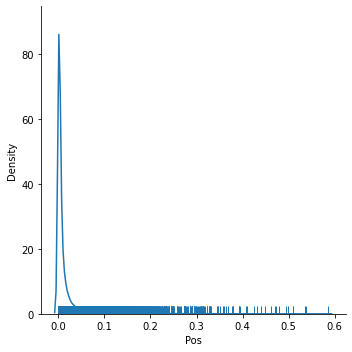

In [18]:
sns.displot(x=preds_df['Pos'], kind='kde', rug=True)

## 5. Examine the chemical structures of the top predicted molecules.

,SMILES,Name,Val,Neg,Pos,Mol
54838,Cn1cncc1C(=O)NC[C@@H](CO)NC(=O)c1cncn1C,ZINC000644062250,0,0.414290,0.585710,
33365,O=C(CNc1ccc(C(=O)NCCO)nn1)NCC(F)(F)F,ZINC000488388380,0,0.461990,0.538010,
21002,O=C(NCCNc1ccc(C(=O)NCCO)nn1)c1cc[nH]n1,ZINC000355577849,0,0.463563,0.536437,
12625,Cn1nnc2cc(C(=O)N[C@H](CO)CN3CCOCC3)cnc21,ZINC000339212694,0,0.491490,0.508510,
12624,Cn1nnc2cc(C(=O)N[C@@H](CO)CN3CCOCC3)cnc21,ZINC000339212693,0,0.491490,0.508510,

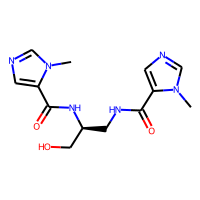
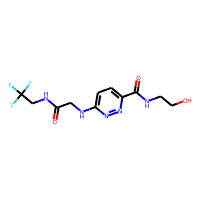
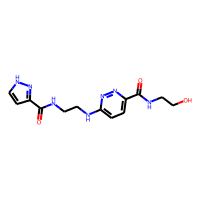
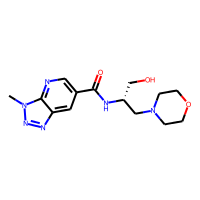
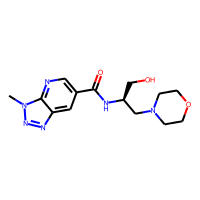

In [21]:
# We can join the dataframe with the scores (DF) with the SMILES strings.
# in order to view the chemical structures of the top-scoring molecules:

combo_df = filtered_mols.join(preds_df, how="outer")
combo_df.sort_values("Pos", inplace=True, ascending=False)

# in order to visualize the molecule
PandasTools.AddMoleculeColumnToFrame(combo_df,"SMILES","Mol")

combo_df.head()

It looks like many of the hits are similar. Let’s look at a few more molecules.

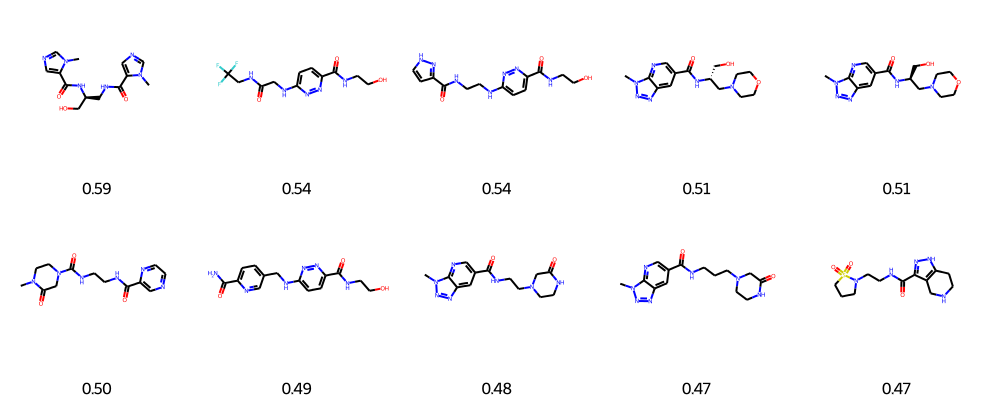

In [22]:
Draw.MolsToGridImage(
  combo_df['Mol'][:10], molsPerRow=5, legends=["%.2f" % x for x in combo_df['Pos'][:10]]
)

## 6. Cluster the selected molecules.

Many of the molecules are very similar and might end up being redundant in our screen. One way to be more efficient would be to cluster the molecules and only screen the highest-scoring molecule in each cluster.

The Butina clustering method is one of the most used methods in cheminformatics. In the Butina clustering method, we group molecules based on their chemical similarity, which is calculated using a comparison of bit vectors (arrays of 1 and 0), also known as chemical fingerprints that represent the presence or absence of patterns of connected atoms in a molecule. These bit vectors are typically compared using a
metric known as the Tanimoto coefficient, which is defined as:

**Tanimoto = A INTERSECTION B / A UNION B**

The numerator is the number of bits that are 1 in both bit vectors A and B. The denominator is the number of bits that are 1 in either vector A or vector B.

In [28]:
""" If the Tanimoto similarity of two molecules is greater than the cutoff, 
the molecules are put into the same cluster. If the similarity is less than the 
cutoff, the molecules are put into different clusters.
"""
def butina_cluster(mol_list, cutoff=0.35):
  fp_list = [
    rdmd.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048)
    for mol in mol_list
  ]
  dists = []
  nfps = len(fp_list)

  for i in range(1, nfps):  
    sims = DataStructs.BulkTanimotoSimilarity(
      fp_list[i], fp_list[:i]
    )
    dists.extend([1 - x for x in sims])

  mol_clusters = Butina.ClusterData(dists, nfps, cutoff, isDistData=True)

  cluster_id_list = [0] * nfps
  for idx, cluster in enumerate(mol_clusters, 1):
    for member in cluster:
      cluster_id_list[member] = idx

  return cluster_id_list

We will only clusterize the 100 top-scoring molecules. 

In [24]:
best_100_df = combo_df.head(100).copy()

,SMILES,Name,Val,Neg,Pos,Mol,Cluster
54838,Cn1cncc1C(=O)NC[C@@H](CO)NC(=O)c1cncn1C,ZINC000644062250,0,0.414290,0.585710,,79
33365,O=C(CNc1ccc(C(=O)NCCO)nn1)NCC(F)(F)F,ZINC000488388380,0,0.461990,0.538010,,78
21002,O=C(NCCNc1ccc(C(=O)NCCO)nn1)c1cc[nH]n1,ZINC000355577849,0,0.463563,0.536437,,77
12625,Cn1nnc2cc(C(=O)N[C@H](CO)CN3CCOCC3)cnc21,ZINC000339212694,0,0.491490,0.508510,,17
12624,Cn1nnc2cc(C(=O)N[C@@H](CO)CN3CCOCC3)cnc21,ZINC000339212693,0,0.491490,0.508510,,17

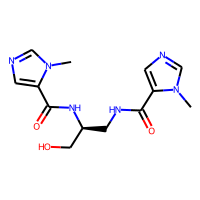
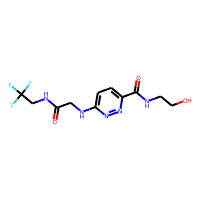
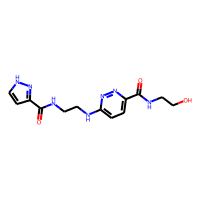
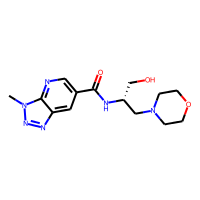
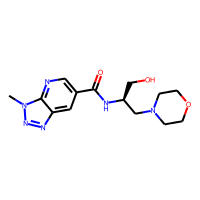

In [29]:
best_100_df["Cluster"] = butina_cluster(best_100_df.Mol)
best_100_df.head()

In [32]:
# Number of clusters
print('Number of clusters', len(best_100_df['Cluster'].unique()))

Number of clusters 79


## 7. Write the selected molecules from each cluster to a CSV file.

Ultimately, we would like to purchase these compounds and screen them experimentally. In order to do this, we need to save a CSV file listing the molecules (one for cluster, the top score) we plan to purchase.

In [36]:
best_cluster_rep_df = best_100_df.drop_duplicates("Cluster")
print(best_cluster_rep_df.columns)
print("Shape: ", best_cluster_rep_df.shape)

Index(['SMILES', 'Name', 'Val', 'Neg', 'Pos', 'Mol', 'Cluster'], dtype='object')
Shape:  (79, 7)


Finally, we can write out a CSV file with the molecules we want to screen:

In [37]:
best_cluster_rep_df.to_csv("best_cluster_represenatives.csv")